In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import distance
from scipy.sparse.csgraph import minimum_spanning_tree
import math
import time


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from modules.dp_bounds_threaded import dp_bounds
# from modules.dp_bounds import dp_bounds

from modules.Bhattacharyya_bounds import Bhattacharyya_bounds



In [3]:
sample_sizes = np.logspace(2, 3.3, 7 , endpoint = True, dtype = int)

sample_sizes

array([ 100,  164,  271,  446,  735, 1211, 1995])

In [4]:
# Set the mean and covariance matrix for each Gaussian distribution

mean1 = [0, 0, 0 , 0 , 0, 0, 0 , 0]
# covariance1 = np.ones((3,3))
covariance1 = np.identity(8)
# covariance1 = [[1, 0, 0],  [0, 1, 0], [0, 0, 0]

mean2 = [2.56, 0, 0 , 0, 0, 0,0, 0 ]
# mean2 = [math.sqrt(1/2), math.sqrt(1/2), 0]

# covariance2 = np.ones((3,3))
covariance2= np.identity(8)


MC_num = 400


### Run the simulation

In [5]:

dp_lst = []

Bha_lst = []


start = time.time()


for i in sample_sizes:
    start = time.time()

    n0, n1 = i, i
    params1  = [mean1, covariance1, n0]
    params2  = [mean2, covariance2, n1]
    
    dp_class = dp_bounds('mv_normal', params1, params2, MC_num, threads = 4, handle_errors= 'worst')
#     dp_class = dp_bounds('mv_normal', params1, params2, MC_num, handle_errors= 'worst')

    Bha_class = Bhattacharyya_bounds('mv_normal', params1, params2, MC_num)

    dp_lst.append(dp_class)
    Bha_lst.append(Bha_class)
    end = time.time()
    print("done with ", i, " in ",  end -start )


done with  100  in  18.029141902923584
done with  164  in  25.94088077545166
done with  271  in  27.07484483718872
done with  446  in  56.39274525642395
done with  735  in  134.19434690475464
done with  1211  in  333.14583444595337
done with  1995  in  1028.2628316879272


### Calculate BER and MSE

In [6]:
dx = 0.001
x = np.arange(-5, 5 + dx, dx)

f0 = np.exp(-0.5 * (x - 0)**2) / np.sqrt(2 * np.pi)
f1 = np.exp(-0.5 * (x - 2.56)**2) / np.sqrt(2 * np.pi)

fmin = np.minimum(f0, f1)

BER = 0.5 * np.sum(fmin * dx)

print("BER 2d:", BER)

BER 2d: 0.10027244449669406


In [7]:
BER_lst = np.ones(MC_num) * BER


def mse(l1, l2):## numpy lists
    return ((l1 - l2)**2).mean(axis=0)

In [8]:
lower_mse_DP = []
upper_mse_DP =[]

lower_mse_Bha = []
upper_mse_Bha =[]


for obj in dp_lst:
    l_mse = mse(BER_lst, obj.get_bounds()[0]) 
    lower_mse_DP.append(l_mse)
    
    u_mse = mse(BER_lst, obj.get_bounds()[1])
    upper_mse_DP.append(u_mse)       

    
for obj in Bha_lst:
    l_mse = mse(BER_lst, obj.get_bounds()[0]) 
    lower_mse_Bha.append(l_mse)
    
    u_mse = mse(BER_lst, obj.get_bounds()[1])
    upper_mse_Bha.append(u_mse)       


### Theoretical values

In [43]:
from modules.Bhattacharyya import Bhattacharyya_bounds as Bhattacharyya_bounds_calc

mean1 = np.array(mean1)
mean2 = np.array(mean2)

theory_bha = Bhattacharyya_bounds_calc([mean1, covariance1], [mean2, covariance2])



Wisler = [.0792, 0.1459]

In [44]:
cases = len(sample_sizes)

## theoretical MSE
bha_theoretical_l= np.ones(cases) * ((theory_bha[0]- BER)**2)
bha_theoretical_u= np.ones(cases) *( (theory_bha[1]-BER)**2)


dp_theoretical_l= np.ones(cases) * ((Wisler[0]- BER)**2)
dp_theoretical_u= np.ones(cases) * ((Wisler[1]- BER)**2)


### Plotting

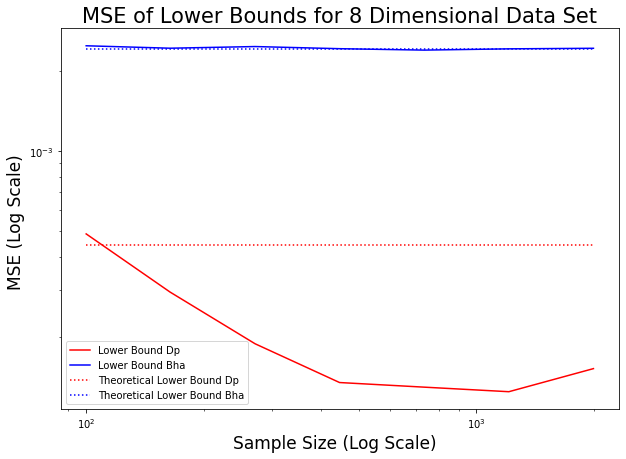

In [45]:
fs =17
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)

ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)

ax.plot(sample_sizes, lower_mse_DP,'r', label='Lower Bound Dp')
ax.plot(sample_sizes, lower_mse_Bha,'b', label='Lower Bound Bha')

ax.plot(sample_sizes, dp_theoretical_l,  'r:', label='Theoretical Lower Bound Dp')

ax.plot(sample_sizes, bha_theoretical_l,  'b:', label='Theoretical Lower Bound Bha')


ax.set_xlabel("Sample Size (Log Scale)  ", fontsize = fs)
ax.set_ylabel("MSE (Log Scale) ", fontsize=fs)
ax.set_title("MSE of Lower Bounds for 8 Dimensional Data Set", fontsize = fs +4)
ax.legend()
# plt.savefig("log_test.png",facecolor=(1,1,1,1))
# ax.set_xticks(sample_sizes)
plt.show()


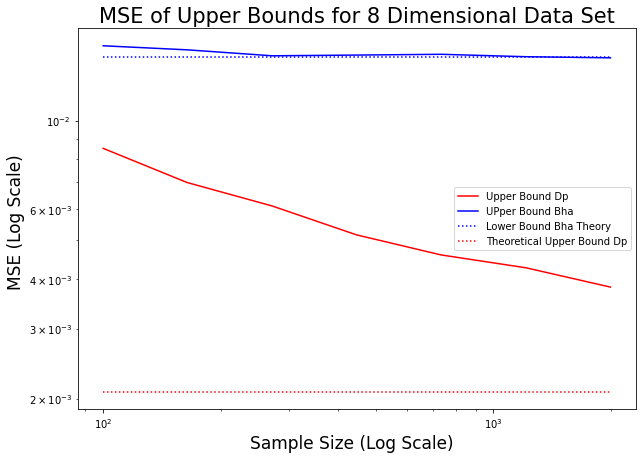

In [46]:
fs =17
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)

ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)

ax.plot(sample_sizes, upper_mse_DP, 'r', label='Upper Bound Dp')
ax.plot(sample_sizes, upper_mse_Bha,'b', label='UPper Bound Bha')

ax.plot(sample_sizes, bha_theoretical_u,  'b:', label='Lower Bound Bha Theory')
ax.plot(sample_sizes, dp_theoretical_u,  'r:', label='Theoretical Upper Bound Dp')

ax.set_xlabel("Sample Size (Log Scale)  ", fontsize = fs)
ax.set_ylabel("MSE (Log Scale) ", fontsize=fs)
ax.set_title("MSE of Upper Bounds for 8 Dimensional Data Set", fontsize = fs +4)
ax.legend()
# plt.savefig("log_test.png",facecolor=(1,1,1,1))
# ax.set_xticks(sample_sizes)
plt.show()

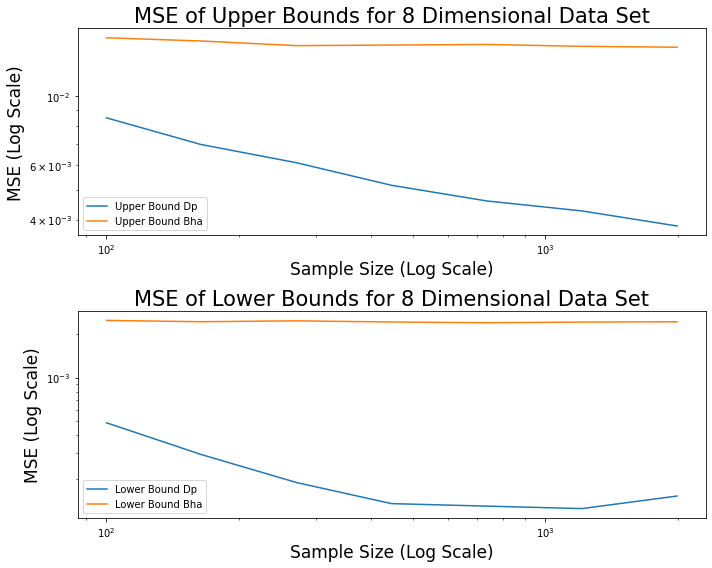

In [12]:
import matplotlib.pyplot as plt

fs = 17
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,8))

# Plot for Upper Bounds
axes[0].set_xscale('log', base=10)
axes[0].set_yscale('log', base=10)
axes[0].plot(sample_sizes, upper_mse_DP, label='Upper Bound Dp')
axes[0].plot(sample_sizes, upper_mse_Bha, label='Upper Bound Bha')
axes[0].set_xlabel("Sample Size (Log Scale)", fontsize=fs)
axes[0].set_ylabel("MSE (Log Scale)", fontsize=fs)
axes[0].set_title("MSE of Upper Bounds for 8 Dimensional Data Set", fontsize=fs + 4)
axes[0].legend()

# Plot for Lower Bounds
axes[1].set_xscale('log', base=10)
axes[1].set_yscale('log', base=10)
axes[1].plot(sample_sizes, lower_mse_DP, label='Lower Bound Dp')
axes[1].plot(sample_sizes, lower_mse_Bha, label='Lower Bound Bha')
axes[1].set_xlabel("Sample Size (Log Scale)", fontsize=fs)
axes[1].set_ylabel("MSE (Log Scale)", fontsize=fs)
axes[1].set_title("MSE of Lower Bounds for 8 Dimensional Data Set", fontsize=fs + 4)
axes[1].legend()
plt.tight_layout()

plt.savefig("Both_bounds.png",facecolor=(1,1,1,1))


plt.show()

In [13]:
validity_dp_l = np.zeros(len(sample_sizes))
validity_dp_u = np.zeros(len(sample_sizes))

validity_Bha_l = np.zeros(len(sample_sizes))
validity_Bha_u =  np.zeros(len(sample_sizes))

for i in range(len(sample_sizes)):
    Bha_l, Bha_u = Bha_lst[i].get_bounds()
    dp_l, dp_u = dp_lst[i].get_bounds()
    for j in range(MC_num):
        if Bha_l[j] < BER:
            validity_Bha_l[i] += 1
        if Bha_u[j] > BER:
            validity_Bha_u[i] += 1
    
        if dp_l[j] < BER:
            validity_dp_l[i] += 1
        if dp_u[j] > BER:
            validity_dp_u[i] += 1
    
        

In [14]:
print(validity_dp_l,  validity_dp_u, validity_Bha_l, validity_Bha_u )

[189. 219. 234. 289. 346. 383. 399.] [399. 400. 400. 400. 400. 400. 400.] [399. 400. 400. 400. 400. 400. 400.] [400. 400. 400. 400. 400. 400. 400.]


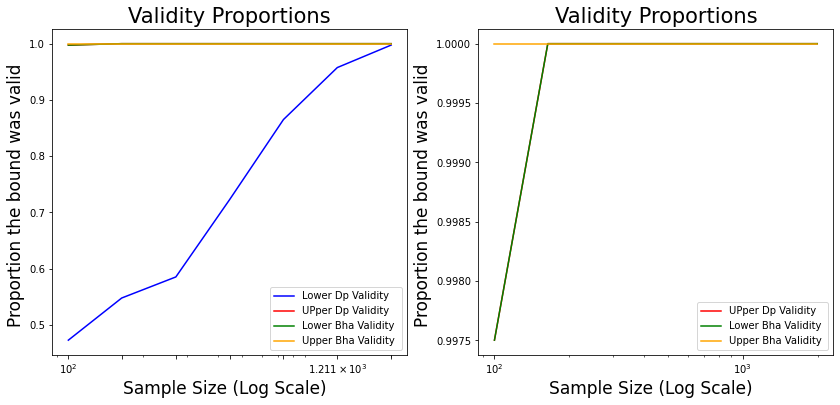

In [68]:
fs =17

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

ax = axes[0]

ax.set_xscale('log', base=10)
# ax.set_yscale('log', base=10)

ax.plot(sample_sizes, validity_dp_l/ MC_num, 'b',  label='Lower Dp Validity ')
ax.plot(sample_sizes, validity_dp_u/ MC_num, 'r', label='UPper Dp Validity ')

ax.plot(sample_sizes, validity_Bha_l/ MC_num,'g', label='Lower Bha Validity ')
ax.plot(sample_sizes, validity_Bha_u/ MC_num, 'orange', label='Upper Bha Validity ')

# ax.set_xticks(sample_sizes)

ax.set_xlabel("Sample Size (Log Scale)  ", fontsize = fs)
ax.set_ylabel("Proportion the bound was valid ", fontsize=fs)
ax.set_title("Validity Proportions" , fontsize = fs +4)
ax.legend()


ax = axes[1]

ax.set_xscale('log', base=10)
# ax.set_yscale('log', base=10)

# ax.plot(sample_sizes, validity_dp_l/ MC_num, 'b',  label='Lower Dp Validity ')
ax.plot(sample_sizes, validity_dp_u/ MC_num, 'r', label='UPper Dp Validity ')

ax.plot(sample_sizes, validity_Bha_l/ MC_num,'g', label='Lower Bha Validity ')
ax.plot(sample_sizes, validity_Bha_u/ MC_num, 'orange', label='Upper Bha Validity ')


ax.set_xlabel("Sample Size (Log Scale)  ", fontsize = fs)
ax.set_ylabel("Proportion the bound was valid ", fontsize=fs)
ax.set_title("Validity Proportions" , fontsize = fs +4)
ax.legend()


# plt.savefig("proportions.png",facecolor=(1,1,1,1))
plt.show()